In [ ]:
#https://blog.devgenius.io/algorithmic-trading-backtesting-a-strategy-in-python-3a136be16ece

In [16]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import warnings

# Ignore printing all warnings
warnings.filterwarnings('ignore')

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [17]:
# downloading historical necessary data for backtesting and analysis
_start = dt.date(2015,1,2)
_end = dt.date(2020,4,30)
ticker = 'MSFT'
df = yf.download(ticker, start = _start, end = _end)

[*********************100%***********************]  1 of 1 completed


In [18]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.926449,27913900,NaN
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.550087,39673900,-0.009239
2015-01-06,46.380001,46.750000,45.540001,45.650002,39.954922,36447900,-0.014786


In [19]:
# creating bollinger band indicators
df['ma20'] = df['Adj Close'].rolling(window=20).mean()
df['std'] = df['Adj Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + (2 * df['std'])
df['lower_band'] = df['ma20'] - (2 * df['std'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band
Date,,,,,,,,
2020-04-23,171.419998,167.577637,32790800,-0.012176,161.229690,8.549662,178.329014,144.130366
2020-04-24,174.550003,170.637482,34277600,0.018095,162.131024,8.543421,179.217866,145.044182
2020-04-27,174.050003,170.148697,33194400,-0.002869,163.321234,7.859113,179.039460,147.603008
2020-04-28,169.809998,166.003723,34392700,-0.024663,163.789497,7.717711,179.224920,148.354074
2020-04-29,177.429993,173.452881,51286600,0.043896,164.753393,7.657327,180.068046,149.438740


In [20]:
# BUY condition
df['signal'] = np.where((df['Adj Close'] < df['lower_band']) &
                        (df['Adj Close'].shift(1) >=       df['lower_band']),1,0)

# SELL condition
df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                          (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band,signal,position,strategy_returns
Date,,,,,,,,,,,
2020-04-23,171.419998,167.577637,32790800,-0.012176,161.229690,8.549662,178.329014,144.130366,0,1.0,-0.012176
2020-04-24,174.550003,170.637482,34277600,0.018095,162.131024,8.543421,179.217866,145.044182,0,1.0,0.018095
2020-04-27,174.050003,170.148697,33194400,-0.002869,163.321234,7.859113,179.039460,147.603008,0,1.0,-0.002869
2020-04-28,169.809998,166.003723,34392700,-0.024663,163.789497,7.717711,179.224920,148.354074,0,1.0,-0.024663
2020-04-29,177.429993,173.452881,51286600,0.043896,164.753393,7.657327,180.068046,149.438740,0,1.0,0.043896


Buy and hold returns: 1.4441294579285486
Strategy returns: 0.37122462261240985


<AxesSubplot: xlabel='Date'>

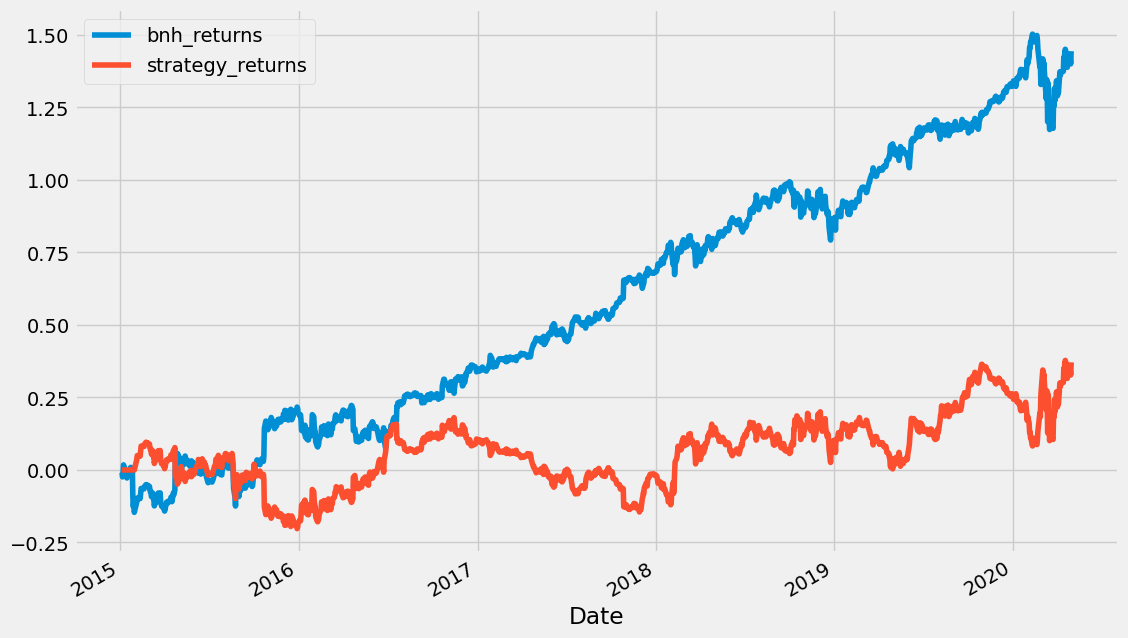

In [21]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

Start date,2015-01-02
End date,2020-04-29
Total months,63
,Backtest
Annual return,3.3%
Cumulative returns,19.1%
Annual volatility,27.1%
Sharpe ratio,0.26
Calmar ratio,0.12
Stability,0.16
Max drawdown,-28.6%


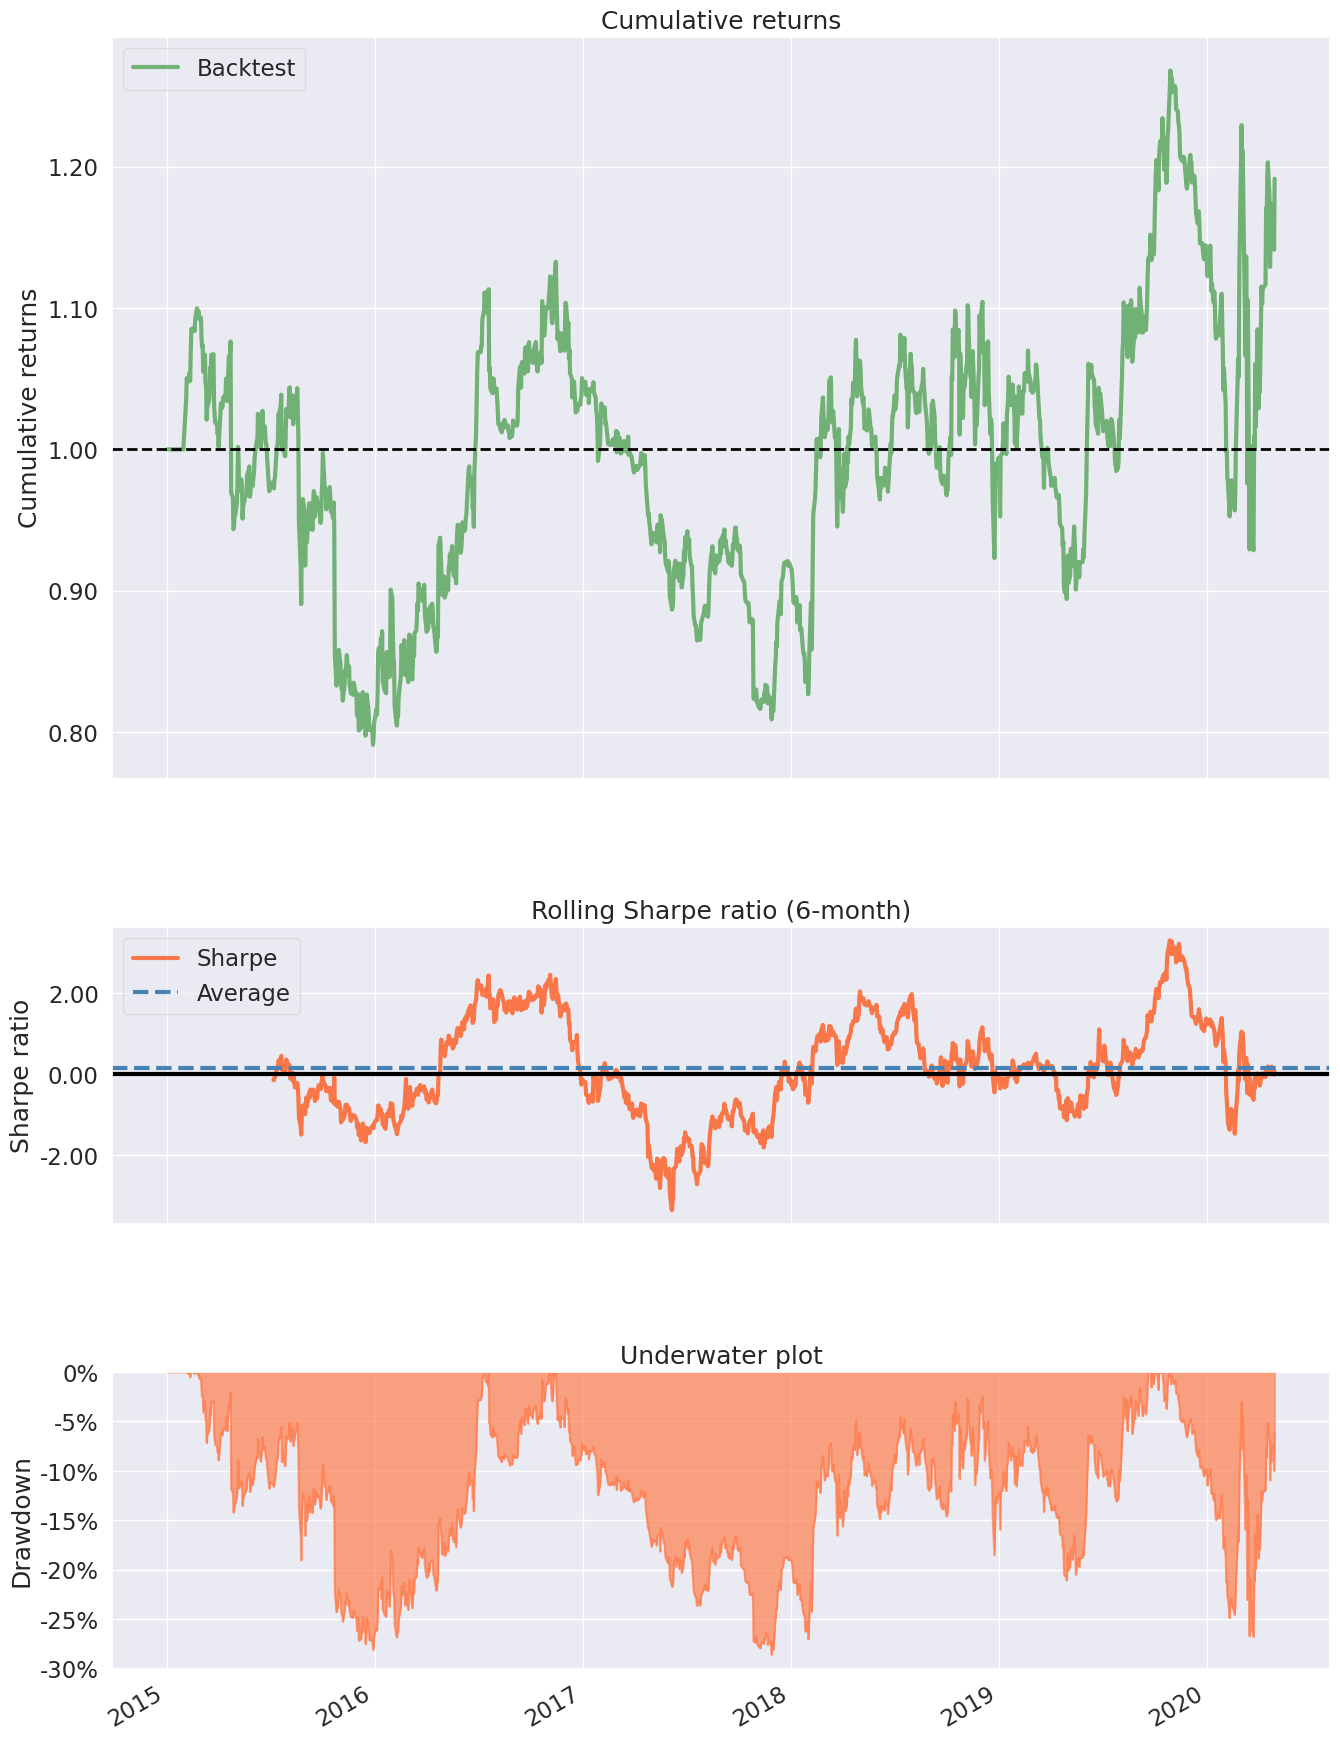

In [22]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())